In [1]:
from contextlib import contextmanager
import matplotlib.pyplot as plt
import numpy as np
from nesopy.model import NativeModel
from nesopy.output import read_hdf5_datasets


In this notebook we illustrate how to use the `NativeModel` class in `nesopy.model` to execute and extract the outputs from runs of a NESO solver which has been built natively on local system. We can view the docstring for the `NativeModel` class as below

In [2]:
NativeModel?


Init signature:
NativeModel(
    solver_executable: str | pathlib.Path,
    base_session_file_path: str | pathlib.Path,
    mesh_file_path: str | pathlib.Path,
    extract_outputs_function: collections.abc.Callable,
    *,
    environment_variables: dict[str, str] | None = None,
    setup_commands: collections.abc.Sequence = (),
    num_omp_threads: int = 1,
    num_mpi_processes: int = 1,
    mpirun_options: str = '',
    redirect_subprocess_streams: bool = False,
)
Docstring:      NESO model using solver installed natively on local filesystem.
Init docstring:
Create a new NESO model wrapper instance.

Args:
    solver_executable: NESO solver executable to use. If the solver executable
        is on the current search path then the solver name can be used directly,
        otherwise a path to the executable should be provided.
    base_session_file_path: Path to XML file defining bae NESO configuration.
        Parameters values defined in this file are used as defaults unless
       

We see that one of the required arguments to `NativeModel` is a function to extract the required outputs from the model `extract_outputs_function`. Specifically here we will use a function which reads HDF5 files outputted by solver and extracts the relevant quantities as NumPy arrays. The `read_hdf5_datasets` helper function from `nesopy.output` provides a simple way of reading datasets at particular [paths](https://docs.hdfgroup.org/hdf5/develop/_h5_g__u_g.html#subsubsec_group_descr_path) or sequences of paths within a HDF5 file:

In [3]:
read_hdf5_datasets?


Signature: read_hdf5_datasets(hdf5_file_path: pathlib.Path, dataset_paths: dict) -> dict
Docstring:
Read one or more datasets at specified paths from a HDF5 file.

Args:
    hdf5_file_path: Path to HDF5 file to read dataset(s) from.
    dataset_paths: Map from string keys to one or more HDF5 paths to datasets within
       the HDF5 file to read. If a key is associated with a single HDF5 path then
       the returned dictionary will contain an entry for the key corresponding to
       the dataset specified by that path as a NumPy array. If a key is associated
       with a sequence of paths, then it is assumed all paths refer to HDF5 datasets
       of the same shape such that they can be stacked in an array with number of
       dimensions one more than each datasets number of dimensions, with the
       returned dictionary then containing an entry for the key corresponding to
       this stacked array, with first axis indexing across the dataset paths.

Returns:
    Dictionary of read

For our particular `extract_outputs` function we read HDF5 datasets from several different files, but if only a subset of outputs are required we would only need to read the files and datasets of interest.

In [4]:
def extract_outputs(output_directory, completed_process, parameters):
    num_steps = parameters["particle_num_time_steps"]
    final_line_field_step = range(
        0, num_steps, parameters["line_field_deriv_evaluations_step"]
    )[-1]
    field_trajectory_steps = range(
        0, num_steps, parameters["particle_num_write_field_energy_steps"]
    )
    return {
        "parameters": parameters,
        "line_field": read_hdf5_datasets(
            output_directory / "Electrostatic2D3V_line_field_evaluations.h5part",
            {
                "x": f"Step#{final_line_field_step}/x",
                "field_value": f"Step#{final_line_field_step}/FIELD_EVALUATION_0",
            },
        ),
        "line_field_derivative": read_hdf5_datasets(
            output_directory / "Electrostatic2D3V_line_field_deriv_evaluations.h5part",
            {
                "x": f"Step#{final_line_field_step}/x",
                "field_value": f"Step#{final_line_field_step}/FIELD_EVALUATION_0",
            },
        ),
        "field_trajectory": read_hdf5_datasets(
            output_directory / "Electrostatic2D3V_field_trajectory.h5",
            {
                "field_energy": [
                    f"step_data/{step}/field_energy" for step in field_trajectory_steps
                ],
                "kinetic_energy": [
                    f"step_data/{step}/kinetic_energy" for step in field_trajectory_steps
                ],
                "potential_energy": [
                    f"step_data/{step}/potential_energy" for step in field_trajectory_steps
                ],
            },
        ) | {"t": np.array(field_trajectory_steps) * parameters["particle_time_step"]}
    }


We define a helper function to plot line field evaluations from the extracted outputs:

In [5]:
def plot_line_field(axes, model_outputs, label=None):
    keys_and_ylabels = {
        "line_field": "Electrostatic potential $\phi(x)$", 
        "line_field_derivative": "Electrostatic potential derivative $\partial\phi(x)$", 
    }
    for ax, (key, ylabel) in zip(axes, keys_and_ylabels.items()):
        ax.plot(model_outputs["line_field"]["x"], model_outputs[key]["field_value"], label=label)
        ax.set(xlabel="Spatial coordinate $x$", ylabel=ylabel)


We also define a helper function to plot the extacted energy trajectory outputs:

In [6]:
def plot_energy_trajectories(axes, model_outputs, label=None):
    keys_and_ylabels = {
        "field_energy": "Field energy $E_f(t)$", 
        "potential_energy": "Potential energy $E_p(t)$", 
        "kinetic_energy": "Kinetic energy $E_k(t)$",
    }
    for ax, (key, ylabel) in zip(axes, keys_and_ylabels.items()):
        ax.plot(model_outputs["field_trajectory"]["t"], model_outputs["field_trajectory"][key], label=label)
        ax.set(xlabel="Time $t$", ylabel=ylabel)


And finally we define a context manager to deal with automatically closing and adjusting layout of Matplotlib figures.

In [7]:
@contextmanager
def autoclosing_subplots_with_tight_layout(*args, **kwargs):
    fig, axes = plt.subplots(*args, **kwargs)
    yield fig, axes
    fig.tight_layout()
    plt.show(fig)
    plt.close(fig)


We create an instance of the `NativeModel` class, passing in the `extract_outputs` function defined above as an argument. We also need to specify the path to the built solver executable (here we use the `Electrostatic2D3V` solver and have added the built NESO `bin` directory to our `PATH` environment variable) and paths to [Nektar++ XML session and mesh files](https://doc.nektar.info/userguide/latest/user-guidech4.html) specifying the problem configuration and spatial mesh respectively (here we use the example files in the same directory as this notebook). We also pass optional arguments to specify to run the solver in parallel across four processes using a message passing interface (MPI) implementation and redirect the `stdout` and `stderr` streams from the subprocess the solver is run in, to the parent process.

In [8]:
model = NativeModel(
    solver_executable="Electrostatic2D3V",
    base_session_file_path="session.xml", 
    mesh_file_path="mesh.xml",
    extract_outputs_function=extract_outputs, 
    num_mpi_processes=4,
    num_omp_threads=1,
    mpirun_options="-map-by core -bind-to hwthread",
    redirect_subprocess_streams=True,
)


The returned `model` object is callable:

In [9]:
model.__call__?


Signature: model.__call__(**parameter_overrides: float | int)
Docstring:
Asynchronously run model with specified parameter overrides.

Keyword Args:
    parameter_overrides: Values to override default parameters in session file
       used to run model with.

Returns:
    Outputs returned by `extract_outputs` function specified when constructing
    model instance.
File:      ~/projects/neso-calibration/src/nesopy/model.py
Type:      method

The default behaviour when calling with no arguments is to run the solver with the default configuration specified in the XML session file passed to the `NativeModel.__init__` method above, with the return value from the call being the outputs returned by running the `extract_outputs` function. The file based outputs of the solver are written to a temporary directory which is automatically removed once the solver execution has completed and the model outputs been extracted. Below we illustrate running the model with the default configuration and plotting the simulated outputs using the helper functions defined earlier.

Particle count  : 400000
Particle Weight : 1.31595e-06
step: 0 0.204629 fe: 8.32253e-12 pe: 0.000738149 ke: 200000 te: 200000
step: 20 0.139786 fe: 3.28837e-09 pe: 0.210481 ke: 200000 te: 200000
step: 40 0.133643 fe: 1.13163e-08 pe: 0.534453 ke: 199999 te: 200000
step: 60 0.129023 fe: 2.31529e-08 pe: 0.750711 ke: 199999 te: 200000
step: 80 0.128663 fe: 3.57193e-08 pe: 0.879516 ke: 199999 te: 200000
step: 100 0.127772 fe: 4.85431e-08 pe: 1.01798 ke: 199999 te: 200000
step: 120 0.128669 fe: 6.00266e-08 pe: 1.11095 ke: 199999 te: 200000
step: 140 0.129417 fe: 6.75588e-08 pe: 1.24334 ke: 199999 te: 200000
step: 160 0.128081 fe: 7.30452e-08 pe: 1.3344 ke: 199999 te: 200000
step: 180 0.127227 fe: 7.37666e-08 pe: 1.29568 ke: 199999 te: 200000
step: 200 0.126332 fe: 7.04961e-08 pe: 1.22111 ke: 199999 te: 200000
step: 220 0.126461 fe: 6.60006e-08 pe: 1.09805 ke: 199999 te: 200000
step: 240 0.127434 fe: 5.81385e-08 pe: 0.932226 ke: 199999 te: 200000
step: 260 0.127008 fe: 5.08458e-08 pe: 0.80332

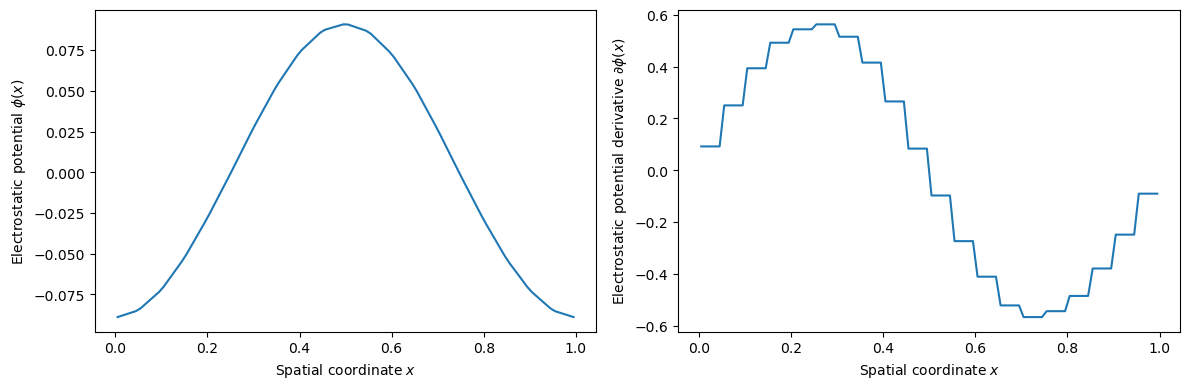

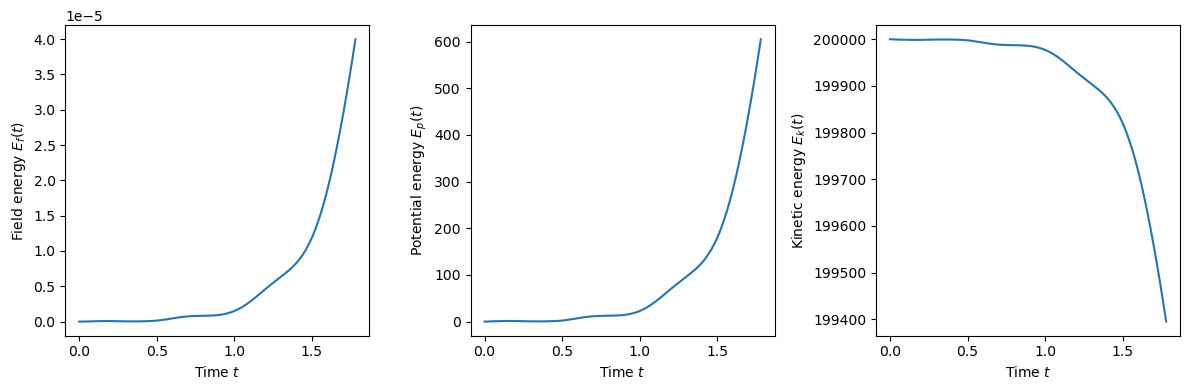

In [10]:
outputs = await model()
with autoclosing_subplots_with_tight_layout(1, 2, figsize=(12, 4), dpi=100) as (fig, axes):
    plot_line_field(axes, outputs, label="Test")
with autoclosing_subplots_with_tight_layout(1, 3, figsize=(12, 4), sharex=True, dpi=100) as (fig, axes):
    plot_energy_trajectories(axes, outputs)


We can also pass keyword arguments when calling the `model` object to override the default values of the parameters specified in the session configuration file. For example:

Particle count  : 400000
Particle Weight : 1.31595e-06
step: 0 0.185867 fe: 2.07748e-12 pe: 0.000188398 ke: 50000 te: 50000
step: 20 0.116407 fe: 8.81078e-10 pe: 0.0692218 ke: 49999.9 te: 50000
step: 40 0.114001 fe: 3.07346e-09 pe: 0.198636 ke: 49999.8 te: 50000
step: 60 0.113662 fe: 6.26297e-09 pe: 0.353801 ke: 49999.6 te: 50000
step: 80 0.114046 fe: 1.01561e-08 pe: 0.491223 ke: 49999.5 te: 50000
step: 100 0.116282 fe: 1.46036e-08 pe: 0.591717 ke: 49999.4 te: 50000
step: 120 0.116315 fe: 1.88477e-08 pe: 0.632306 ke: 49999.4 te: 50000
step: 140 0.119026 fe: 2.23459e-08 pe: 0.637865 ke: 49999.4 te: 50000
step: 160 0.121338 fe: 2.48918e-08 pe: 0.634605 ke: 49999.4 te: 50000
step: 180 0.121234 fe: 2.6497e-08 pe: 0.630958 ke: 49999.4 te: 50000
step: 200 0.121713 fe: 2.74515e-08 pe: 0.608585 ke: 49999.4 te: 50000
step: 220 0.122888 fe: 2.72559e-08 pe: 0.552357 ke: 49999.4 te: 50000
step: 240 0.123859 fe: 2.58696e-08 pe: 0.492347 ke: 49999.5 te: 50000
step: 260 0.123986 fe: 2.34364e-08 pe: 0

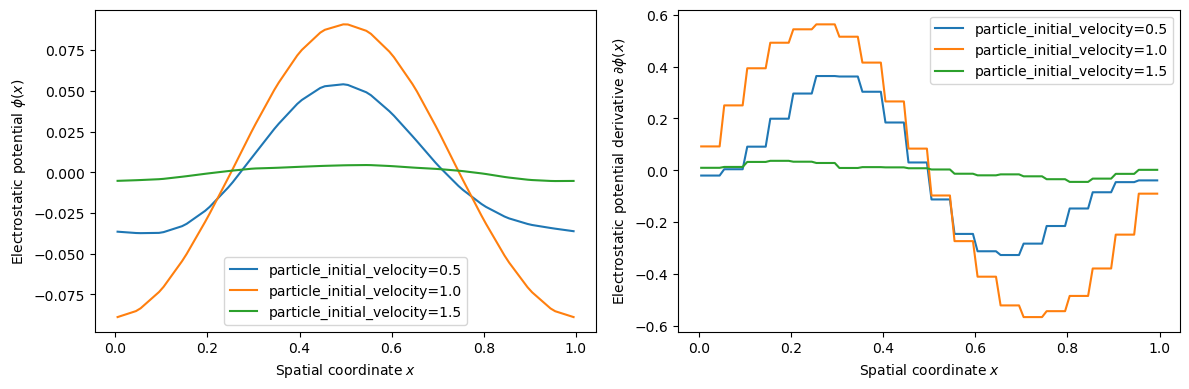

In [11]:
with autoclosing_subplots_with_tight_layout(1, 2, figsize=(12, 4), dpi=100) as (fig, axes):
    for particle_initial_velocity in (0.5, 1., 1.5):
        outputs = await model(particle_initial_velocity=particle_initial_velocity)
        plot_line_field(axes, outputs, label=f"{particle_initial_velocity=}")
    for ax in axes:
        ax.legend()
